<a href="https://cocl.us/DL0320EN_TOP_IMAGE?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0320EN/Assets/Images/Top.png" width="750" alt="IBM 10TB Storage" />
</a>


<h1>Classifying European Money Denominations: Training a Pre-trained model  </h1>


<h2>Table of Contents</h2>


<p>In this lab, you will train the pre-trained model to classify the European currency. You will use the dataset object you created in the previous lab.</p>
<ul>
    <li><a href="https://#gen">Create Image Dataset Generator</a></li>
    <li><a href="https://#ques">Questions</a>
        <ol>
            <li><a href="https://q31/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01">Question 3.1: Preparation</a></li>
            <li><a href="https://q32/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01">Question 3.2: Train the model</a></li>
            <li><a href="https://q33/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01">Question 3.3: Plot 5 Random Images with their predictions</a></li>
            <li><a href="https://q34/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01">Question 3.4: Use the second model <code>Densenet121</code> to do the prediction</a></li>
        </ol>
    </li>
    <li><a href="https://#save">Save the trained model</a></li>
</ul>

<p>Estimated Time Needed: <b>60 mins</b></p>
<hr>


<h2>Preparation</h2>


<a href="https://cocl.us/DL0320EN_storage?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0320EN/Assets/Images/ObjectStorage.png" width="750" alt="cognitive class" />
</a>


Download the datasets you needed for this lab.


In [1]:
# You can comment out this box when you already have the dataset
# Step 1: Ctrl + A : Select all
# Step 2: Ctrl + / : Comment out all; if everything selected has been comment out alreaday, then uncomment all

# Download Training Dataset
!wget --quiet -O /resources/data/training_data_pytorch.tar.gz https://cocl.us/DL0320EN_TRAIN_TAR_PYTORCH
!tar -xzf  /resources/data/training_data_pytorch.tar.gz -C /resources/data --exclude '.*'

# Download Validation Dataset
!wget --quiet -O /resources/data/validation_data_pytorch.tar.gz https://cocl.us/DL0320EN_VALID_TAR_PYTORCH
!tar -xzf  /resources/data/validation_data_pytorch.tar.gz -C /resources/data --exclude '.*'

Import the PyTorch Modules needed in the lab.


In [2]:
# Import PyTorch Modules will be used in the lab

import torch 
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

Import Non-PyTorch Modules


In [3]:
# Import Non-PyTorch Modules will be used in the lab

import time
from imageio import imread
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np

<hr>


<h2 id="gen">Create Dataset Class and Object</h2>


In this section, you use the dataset class from the last section.


The denomination, file name and the class variable for the training and validation data are stored in the following csv file.


In [4]:
# Url that contains CSV files

train_csv_file = 'https://cocl.us/DL0320EN_TRAIN_CSV'
validation_csv_file = 'https://cocl.us/DL0320EN_VALID_CSV'

The training images and validation images  are stored in the following directories.


In [5]:
# Absolute path for finding the directory contains image datasets

train_data_dir = '/resources/data/training_data_pytorch/'
validation_data_dir = '/resources/data/validation_data_pytorch/'

Use  the dataset class you created in the last lab. You can cut and paste it to here:


In [6]:
# Create Dateaset Class

class Dataset(Dataset):
    
    # Constructor
    def __init__(self, csv_file, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data_name = pd.read_csv(csv_file)
        self.len = self.data_name.shape[0] 
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        img_name = self.data_dir + self.data_name.iloc[idx, 2]
        image = Image.open(img_name)
        y = self.data_name.iloc[idx, 3]
        if self.transform:
            image = self.transform(image)
        return image, y

Use the constructor <code>compose</code> to perform the following sequence of transformations in the order they are given, call the object <code>composed</code>


In [7]:
# Construct the composed object for transforming the image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.Resize((224, 224))
                               , transforms.ToTensor()
                               , transforms.Normalize(mean, std)])

Create a training dataset and validation dataset object using the csv file stored in the variables the <code>train_csv_file</code> and <code>validation_csv_file</code>. The directories are stored in the variable <code>train_data_dir</code> and <code>validation_data_dir</code>. Set the parameter <code>transform</code> to the object <code>composed</code>.


In [8]:
# Create the train dataset and validation dataset

train_dataset = Dataset(transform=composed
                        ,csv_file=train_csv_file
                        ,data_dir=train_data_dir)

validation_dataset = Dataset(transform=composed
                          ,csv_file=validation_csv_file
                          ,data_dir=validation_data_dir)

<hr>


<h2 id="ques">Questions</h2>


<h3 id="q31">Question 3.1: Preparation</h3><b>5 points</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true.


In [13]:
# Step 1: Load the pre-trained model resnet18

# Type your code here
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jupyterlab/.cache/torch/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<b>Step 2</b>: The following lines of code will set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [15]:
# Step 2: Set the parameter cannot be trained for the pre-trained model

# Type your code here
for param in model.parameters():
    param.requires_grad=False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs.


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 7 different bills. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [16]:
# Step 3: Re-defined the last layer

# Type your code here
model.fc=nn.Linear(512,7)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [17]:
# Print the model (PLEASE DO NOT MODIFY THIS BOX)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h3 id="q32">Question 3.2: Train the model</h3><b>5 points</b>


<b>Step 1</b>: Create a cross entropy criterion function


In [22]:
# Step 1: Create the loss function

# Type your code here
criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size is <i>15</i> and <i>10</i> respectively .


In [18]:
# Step 2: Create the data loader

# Type your code here
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=15)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10)

<b>Step 3</b>: Use the following optimizer to minimize the loss


In [19]:
# Step 3: Use the pre-defined optimizer Adam with learning rate 0.003

# Type your code here
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.003)

<b>Step 4</b>: Train the model for 20 epochs, save the loss in a list as will as the accuracy on the validation data for every epoch. The entire process may take 6.5 minutes. Print the validation accuracy for each epoch during the epoch loop. Then, plot the training loss for each epoch and validation error for each epoch.


In [23]:
# Step 4: Train the model

N_EPOCHS = 20
loss_list = []
accuracy_list = []
correct = 0
n_test = len(validation_dataset)

# Type your code here
for epoch in range(N_EPOCHS):
    loss_sublist=[]
    for x, y in train_loader:
        model.train()
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))
    
    correct=0
    for x_test, y_test in validation_loader:
        model.eval()
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat==y_test).sum().item()
    accuracy = correct/n_test
    accuracy_list.append(accuracy)

<b>Step 5</b>: Plot the training loss for each iteration<br> <b>(Your peer reviewer is going to mark based on what you plot here.)</b>


Text(0.5, 1.0, 'Average Loss per Epoch vs Epoch')

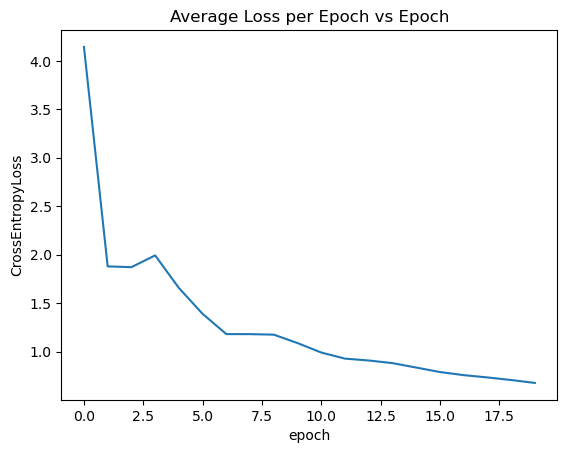

In [25]:
# Step 5: Plot the loss for training dataset

# Type your code here
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('CrossEntropyLoss')
plt.title('Average Loss per Epoch vs Epoch')

<b>Step 6</b>: Plot the validation accuracy for each epoch<br> <b>(Your peer reviewer is going to mark based on what you plot here.)</b>


Text(0.5, 1.0, 'Accuracy vs Epoch')

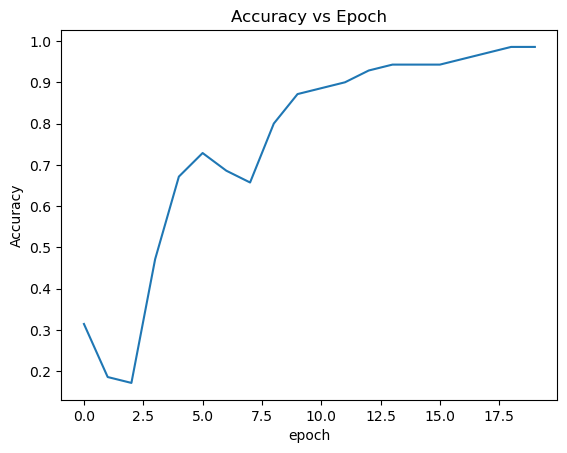

In [26]:
# Step 6: Plot the accuracy for valdiation dataset

# Type your code here
plt.plot(accuracy_list)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')

<h3 id="q33">Question 3.3: Plot 5 Random Images with their predictions</h3><b>5 points</b>


Create a test dataset using validation data. And, create your own <code>plot_random_image()</code> function to plot 5 random images which index is in the <code>numbers</code> list. Run the function to plot image, print the predicted label and print a string indicate whether it has been correctly classified or mis-classified.<br> <b>(Your peer reviewer is going to mark based on what you plot here.)</b>


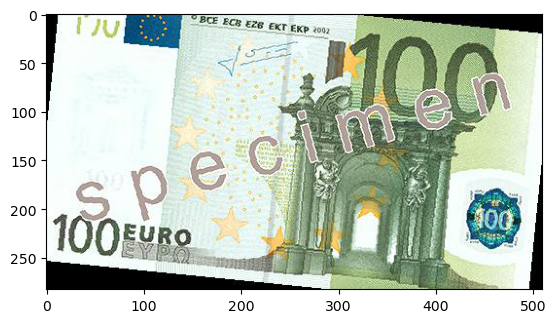

predicted: $100 (Correctly prediction)


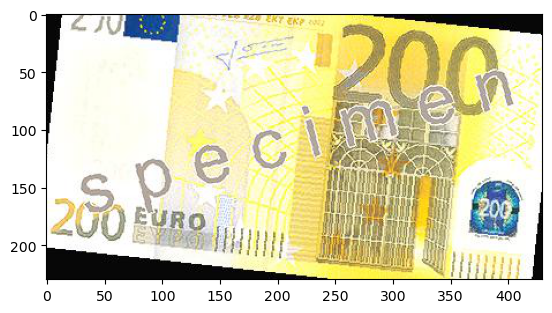

predicted $200 (Correctly prediction)


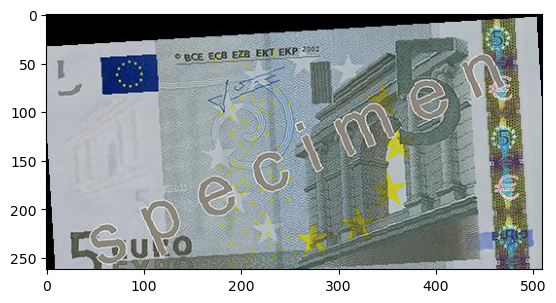

predicted: $5 (Correctly prediction)


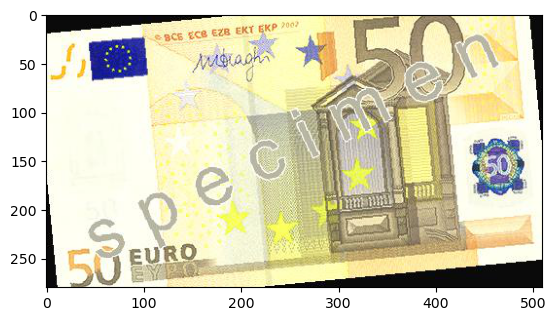

predicted: $50 (Correctly prediction)


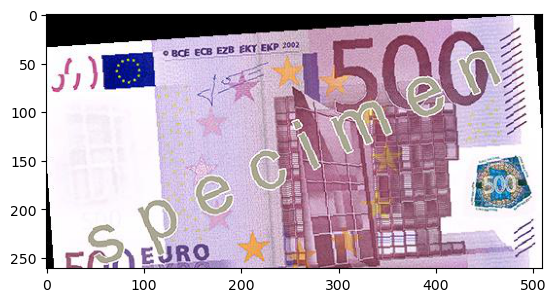

predicted $500 (Correctly prediction)


In [65]:
# Plot the images with labels

look_up = {0: 'predicted: $5'
           , 1: 'predicted: $10'
           , 2: 'predicted: $20'
           , 3: 'predicted: $50'
           , 4: 'predicted: $100'
           , 5: 'predicted $200'
           , 6: 'predicted $500'}
random.seed(0)
numbers = random.sample(range(70), 5)

# Type your code here
test_dataset = Dataset(transform=composed
                          ,csv_file=validation_csv_file
                          ,data_dir=validation_data_dir)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1)

def plot_random_image(numbers, data):
    model.eval()
    prediction = ''
    
    for num in numbers:  
        
        z = model(data[num][0].unsqueeze(0)) # added batch dimention = 1, to transform in 4dim tensor
        _, yhat = torch.max(z.data, 1)
        yhat = int(yhat)
        
        img_name = data.data_dir + data.data_name.iloc[num, 2]
        image = Image.open(img_name)
        plt.imshow(image)
        plt.show()      

        prediction_type = '(Correctly prediction)' if yhat==data[num][1] else 'Incorrectly prediction'
        print(look_up[yhat], prediction_type)
    
plot_random_image(numbers, test_dataset)   

<h3>Question 3.4: Use the second model <code>Densenet121</code> to do the prediction</h3><b>3 points</b>


Repeat the steps in Question 3.1, 3.2 to predict the result using <code>models.densenet121</code> model. Then, print out the last validation accuracy.


<p>Steps:</p>
<ol>
    <li>Load the pre-trained model Densenet</li>
    <li>Replace the last classification layer with only 7 classes</li>
    <li>Set the configuration (parameters)</li>
    <li>Train the model</li>
    <li>Print the last validation accuracy</li>
</ol>


Hint:

<ul>
    <li>The second last layer for this model has 1024 outputs.</li>
    <li>The last layer for <code>Densenet121</code> can be accessed by <code>model.classifier</code></li>
    <li>Use the criterion function <code>nn.CrossEntropyLoss()</code></li>
    <li>Train Batch Size: 15; Validation Batch Size: 10</li>
    <li>Optimizer: Adam with learning rate 0.003</li>
    <li>10 Epoches. Otherwise, it will take too long.</li>
</ul>


You are welcome to try any pattern of setting and find out the best result. Please name the model variable as <code>model_des</code>.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [66]:
# Use densenet121 to train the model and print out the last validation accuracy.

# Type your code here
model_des = models.densenet121(pretrained=True)

for param in model_des.parameters():
    param.requires_grad=False
model_des.classifier=nn.Linear(1024,7)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/jupyterlab/.cache/torch/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [67]:
print(model_des)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [68]:
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=15)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10)

optimizer = torch.optim.Adam([parameters for parameters in model_des.parameters() if parameters.requires_grad], lr=0.003)

N_EPOCHS = 10
loss_list = []
accuracy_list = []
correct = 0
n_test = len(validation_dataset)

# Type your code here
for epoch in range(N_EPOCHS):
    loss_sublist=[]
    for x, y in train_loader:
        model_des.train()
        optimizer.zero_grad()
        z = model_des(x)
        loss = criterion(z, y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))
    
    correct=0
    for x_test, y_test in validation_loader:
        model_des.eval()
        z = model_des(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat==y_test).sum().item()
    accuracy = correct/n_test
    accuracy_list.append(accuracy)

Text(0.5, 1.0, 'Average Loss per Epoch vs Epoch, densenet121')

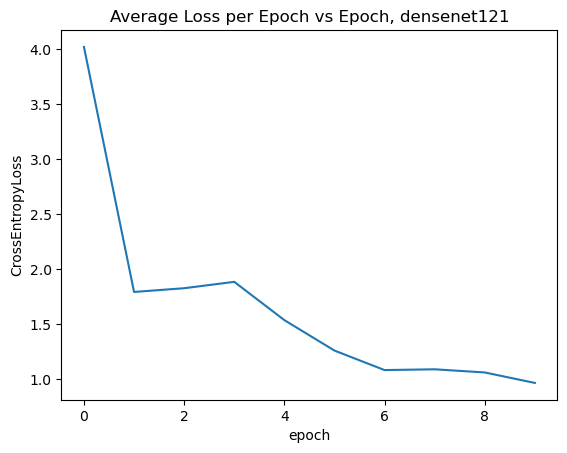

In [69]:
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('CrossEntropyLoss')
plt.title('Average Loss per Epoch vs Epoch, densenet121')

Text(0.5, 1.0, 'Accuracy vs Epoch, densenet121')

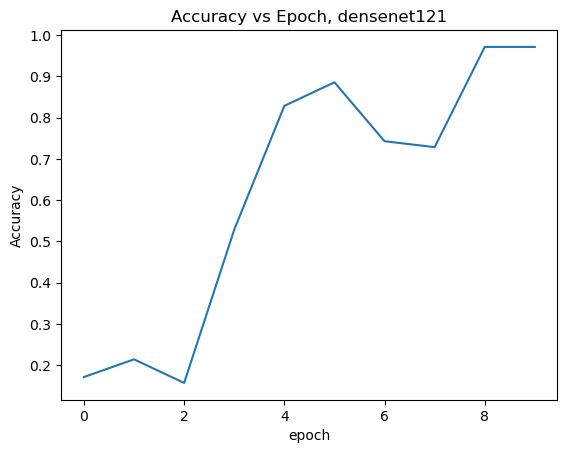

In [70]:
plt.plot(accuracy_list)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch, densenet121')

<h2 id="#save">Save the trained model</h2>


Save the trained model for the following chapters


In [71]:
# Save the model

torch.save(model, "resnet18_pytorch.pt")
torch.save(model_des, "densenet121_pytorch.pt")

<a href="https://cocl.us/DLO0320EN_notebook_bott?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0320EN/Assets/Images/Bottom.png" width="750" alt="cognitive class" />
</a>


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01">Mavis Zhou</a>, <a href="https://www.linkedin.com/in/yi-leng-yao-84451275/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01">Yi Leng Yao</a>


<hr>


Copyright © 2018 <a href="https://cognitiveclass.ai/?utm_medium=dswb&utm_source=bducopyrightlink&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0320ENSkillsNetwork21408567-2022-01-01">MIT License</a>.
